In [1]:
# Import external libraries
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d

In [2]:
# Lets define a few constants for the assignment
island_radius = 5 # [km] the radius of the island
crab_mass = 1 # [kg] - mass of one metal crab
max_dist = 0.2 # [km] - max distance a crab can move in a day

In [3]:
# Define helper functions for converting between coordinate systems
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (r,phi)

def pol2cart(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return (x,y)

# Problem 3A

First we will define a function for moving the crab during the day. We call this daily_move. It will choose a random direction (polar coordinates angle) and move max_dist=200 m that way. If the crab is within the island still the new position is accepted. If not it moves the distance to the edge along that direction.

Here is notes on how we add two vectors in polar coordinates. The equations used in the daily_move function uses the formulas for r and phi directly.
https://math.stackexchange.com/questions/1365622/adding-two-polar-vectors

This function can then be used N times to simualte more days. A function doing this will be called N_move.

In [4]:
# Define a function that simulates the crab movement of one day
def daily_move(r0, phi0, return_dist=False):
    """
    INPUTS:
    r0 = radial distance to center of island
    phi0 = azimuth angle in polar coordinates (angle with x-axis positive direction)
    
    OUTPUT:
    new_r = radial distance of new position
    new_phi = azimuth angle of new position
    """
    
    # Get the random direction
    direction = rd.uniform(low=0,high=2*np.pi)
    
    # Get the resulting vector mag obtained from the max dist (new position) [eq. from link]
    max_r = np.sqrt( r0**2 + max_dist**2 + 2*r0*max_dist*np.cos(direction-phi0) )
    
    # Check whether we are still on the island after a 200 m step
    if max_r <= island_radius: 
        
        new_r = max_r
        new_dist = max_dist
        
        # Calculate the new phi [eq. from link]
        new_phi = phi0 + np.arctan2(max_dist*np.sin(direction-phi0), r0+max_dist*np.cos(direction-phi0) )
        
    # if not stop the crab at the edge
    else:
        # FIND THE RIGHT DISTANCE INSTEAD OF MAX_DIST WHICH MAKES MAX_R BE EQUAL TO THE ISLAND RADIUS
        
        # Define the coefficients of the second degree eq
        a = 1
        b = 2*r0 * np.cos(direction-phi0)
        c = r0**2 - island_radius**2
        
        # Get roots
        root1 = (-b + np.sqrt(b**2-4*a*c)) / 2*a
        root2 = (-b - np.sqrt(b**2-4*a*c)) / 2*a
        
        # Chose the positive value as the solution, i.e. the distance we should move in the direction
        new_dist = np.max([root1,root2])
        
        # Now lets find the actual new_r
        new_r = island_radius
        
        # Calculate the new phi [eq. from link]
        new_phi = phi0 + np.arctan2(new_dist*np.sin(direction-phi0), r0+new_dist*np.cos(direction-phi0) )
    
    # Return the distance travelled if asked for
    if return_dist:
        return new_r, new_phi, new_dist
        
    # Return the new polar coordinates of the position
    else:
        return new_r, new_phi

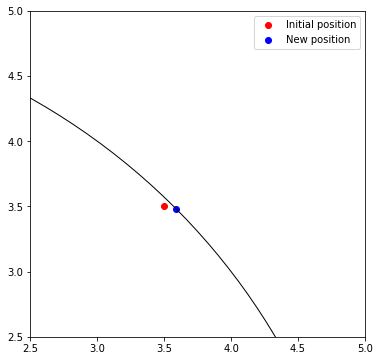

In [5]:
## Test the daily_move function ##

# Plotting
fig, ax = plt.subplots(figsize=(6,6))

# Draw island
island = plt.Circle((0, 0), island_radius, fill=False, color='k')
ax.add_patch(island)

# Chose a starting position close to the edge
x0_, y0_ = 3.5, 3.5
ax.scatter(x0_, y0_, color='r', label='Initial position')

# Move the crab
r0_, phi0_ = cart2pol(x0_,y0_)
rd.seed(4)
r1, phi1 = daily_move(r0_,phi0_)
x1, y1 = pol2cart(r1, phi1)

# Plot the new position
ax.scatter(x1,y1,color='b', label='New position')
plt.xlim(2.5,5.0)
plt.ylim(2.5,5.0)
ax.legend()
plt.show()

In [6]:
# Define a function that simulates the crab movement of N days
def N_move(r0, phi0, N_days, system='cart', seed=1, return_dist=False):
    """
    INPUTS:
    r0 = radial distance to center of island
    phi0 = azimuth angle in polar coordinates (angle with x-axis positive direction)
    N_days = number of days to let the crab move for
    system = 'cart' or 'pol' (whether the output should be cartesian or polar coordinates)
    
    OUTPUT:
    """
    
    # Set random seed
    rd.seed(int(seed))
    
    # Create arrays for 1st and 2nd coordinate - will be filled with (x,y) or (r,phi) depending on output
    first_coords = []
    sec_coords = []
    
    # Loop over number of days to move for
    for i in range(N_days):
        
        # Move and get the position
        r, phi = daily_move(r0, phi0, return_dist)
        
        # Store results if wanted in polar
        if system == 'pol':
            
            first_coords.append(r)
            sec_coords.append(phi)
            
        elif system == 'cart':
            
            x,y = pol2cart(r, phi)
            first_coords.append(x)
            sec_coords.append(y)
            
        # Let the current setting be the initial setting in next loop
        r0, phi0 = r, phi
        
    return first_coords, sec_coords

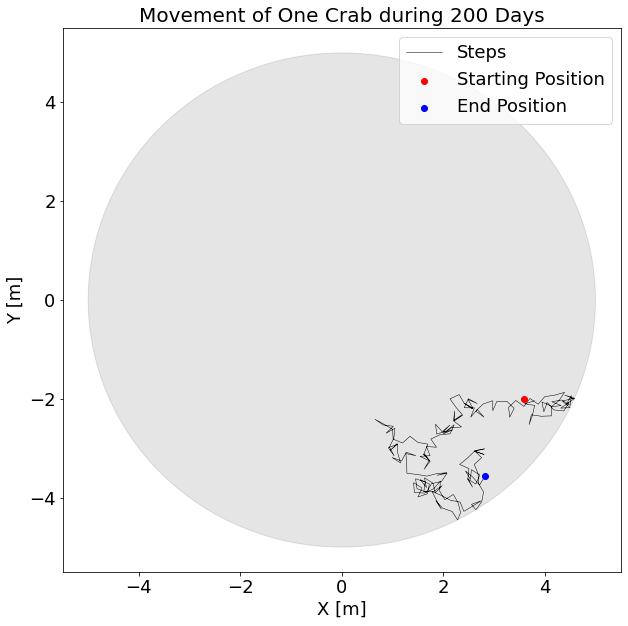

In [7]:
## Produce the plot wanted in the problem ##

# Simulate
x0_, y0_ = 3.6, -2.0
r0_, phi0_ = cart2pol(x0_,y0_)
x_coordinates, y_coordinates = N_move(r0_, phi0_, N_days=200, system='cart', seed=4, return_dist=False)

# Plot --------------
fig, ax = plt.subplots(figsize=(10,10))

# Draw island
island = plt.Circle((0, 0), island_radius, alpha=0.1, color='k')
ax.add_patch(island)

# Plot starting and ending position
ax.scatter(x0_, y0_, color='r',zorder=2, label='Starting Position')
ax.scatter(x_coordinates[-1], y_coordinates[-1], color='b',zorder=2, label='End Position')

# Plot the crabs walk
ax.plot(x_coordinates, y_coordinates, color='k', linewidth=0.5, zorder=0, label='Steps')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.set_title('Movement of One Crab during 200 Days', fontsize=20)
ax.set_xlabel('X [m]', fontsize=18)
ax.set_ylabel('Y [m]', fontsize=18)
ax.legend(prop={'size':18})
plt.show()

# Problem 3B

To solve this we will let crabs move for up to max_step days. We will let return_dist be True in the daily_move function, so we can keep track of the total distance travelled. If the edge is hit we stop the simulation, if not we let it continue for max_step so it is not able to go on forever.

In [8]:
# Define a function that simulates the crab thing until it reaches the edge
def edge_travel(r0, phi0, seed=1, max_steps=500, return_dist = True):
    """
    INPUT:
    r0, phi0 = starting position
    seed = random integer
    max_steps = maximum number of days we let the crab walk if it never hits an edge
    return_dist = boolean that should be true, so daily_move will return the distance travelled a given day
    
    OUTPUT:
    total_dist = Distance in meters before edge was reached
    edge_found = boolean: True if we stopped at the edge, False if we stops due to max_steps
    """
    
    # Set up random seed
    rd.seed(int(seed))
    
    # Set up a counter for the distance travelled
    total_dist = 0
    
    # Set up a boolean for keeping track of whether the edge was hit
    edge_found = False
    
    # Loop over max steps
    for i in range(int(max_steps)):
        
        # Move and get the position and travelled distance
        r, phi, dist = daily_move(r0, phi0, return_dist)
        
        # Add distance to counter
        total_dist += dist
        
        # Check whether we found the edge (then distance is smaller than max_dist)
        if dist < max_dist:
            edge_found = True
            return total_dist, edge_found
        
        # Let the current setting be the initial setting in next loop
        r0, phi0 = r, phi
    
    # If edge was not hit return the total distance
    return total_dist, edge_found

In [9]:
# Define parameters from assignment
N_experiments = 501
x0_, y0_ = 3.6, -2.0
r0_, phi0_ = cart2pol(x0_,y0_)

In [10]:
# Empty array to collect data in
distances_travelled = np.zeros(N_experiments)
edge_found_mask = []

# Loop over experiments to collect data
for i in range(N_experiments):
    
    # Simulate
    distance, edge_bool = edge_travel(r0_, phi0_, seed=i, max_steps=2000)
    
    # Store data
    distances_travelled[i] = distance
    edge_found_mask.append(edge_bool)

In [11]:
# Check whether some of the experiments did not find the edge
np.where(edge_found_mask==False)

(array([], dtype=int64),)

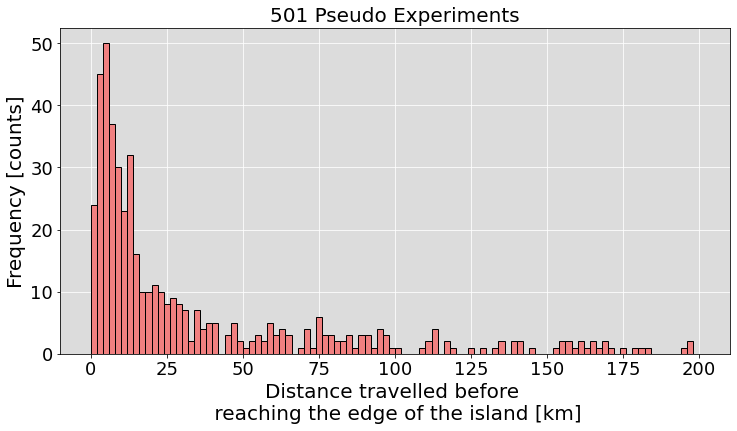

In [12]:
# Plot in histogram
fig, ax = plt.subplots(figsize=(12,6))

# Distances (notice we convert to km by dividing with 1000)
ax.set_facecolor('gainsboro')
ax.grid(color='white')
ax.hist(distances_travelled, bins=np.arange(0,201,2), color='lightcoral',zorder=2, ec='k')

ax.set_title('501 Pseudo Experiments', fontsize=20)
ax.set_xlabel(f'Distance travelled before \n reaching the edge of the island [km]', fontsize=20)
ax.set_ylabel(f'Frequency [counts]', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

# Problem 3C

In [13]:
# Define parameters from problem description
battle_zone_radius = 0.175 # [km]

## Starting positions

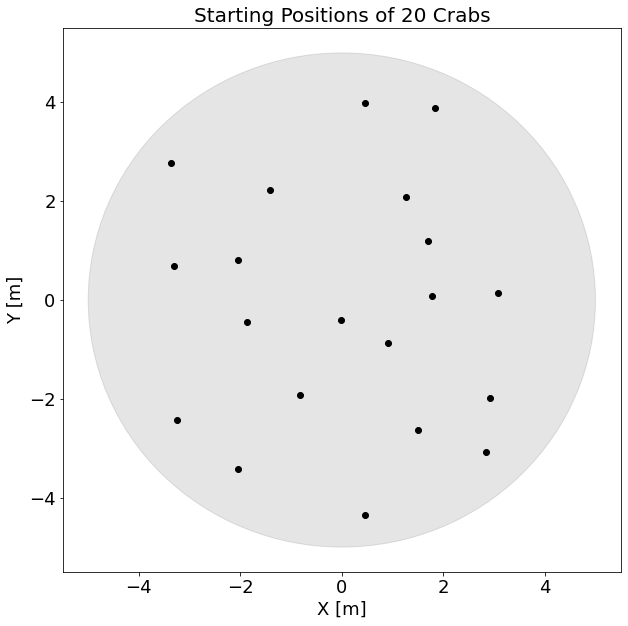

In [18]:
# Extract starting positions from the file (and convert to meters)
CrabData = np.genfromtxt('Data/CrabStartPositions.txt')
x_starts, y_starts = CrabData[:,0], CrabData[:,1]

# Plot the starting positions
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x_starts, y_starts, color='k')

# Draw island
island = plt.Circle((0, 0), island_radius, alpha=0.1, color='k')
ax.add_patch(island)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.set_title('Starting Positions of 20 Crabs', fontsize=20)
ax.set_xlabel('X [m]', fontsize=18)
ax.set_ylabel('Y [m]', fontsize=18)
plt.show()

## Battle_tournament

In [19]:
def battle_tournament(positions):
    """
    INPUT:
    positions = an array with shape (N_crabs, 2) containing the CARTESIAN cordinates of the crabs (alive)
    
    OUTPUT:
    tournament = a list of arrays, each containing two indices, i.e. the crabs to battle. 
                 The first element defines the first battle. 
                 EX: array([ [0,3],[0,1],[2,3] ]) means that first Crab with idx 0 should battle Crab 3.
                     Then Crab 0 battles Crab 1. Then Crab 2 battles Crab 3. Since each battles result in
                     death we have to later implements checks that both contestants are alive. Which means
                     this tournament would have only 2 battles depending on whether Crab 0 or Crab 3 win
                     the first battle.
    """
    
    # Compute distances between all crabs
    dist_mat = distance_matrix(positions, positions)

    # Modify lower triangular matrices to include NaNs so we do not repeat distances
    mask = np.tril_indices(len(positions))
    dist_mat[mask] = np.nan
    
    # Get indices of distances below 175 m
    battle_indices = np.argwhere(dist_mat < battle_zone_radius)
    
    # Get distances of those indices
    battle_mask = (dist_mat < battle_zone_radius)
    battle_distances = dist_mat[battle_mask]
    
    # Sort the battle indices according to smallest distance first creating the tournament
    sort_mask = np.argsort(battle_distances)
    tournament = battle_indices[sort_mask]
    
    return tournament

In [20]:
## Test it ##
test_pos = np.array([[1,2],[1,2.1],[3,4],[1.15,2]])
test_tournament = battle_tournament(test_pos)
test_tournament

array([[0, 1],
       [0, 3]])

## Battle function

In [21]:
def battle(tournament, mass_arr):
    """
    INPUT:
    tournament = a list of arrays, each containing two indices, i.e. the crabs to battle. 
                 The first element defines the first battle. (from battle_tournament function)
    mass_arr = an array with len N_crabs containing the mass in kilos of the crabs
    
    OUTPUT:
    status_arr = a boolean array with len N_crabs informing whether a crab is dead or not (0=dead, 1=alive)
    mass_arr = an array with len N_crabs containing the mass in kilos of the crabs
    """
    
    # Define a status array, all input crabs are alive in the beginning
    status_arr = np.ones(len(mass_arr),dtype=bool)
    
    # Loop over the games in tournament (battles in order of battles to perform)
    for game in tournament:
        
        # Get indices of participating crabs in game
        crab_1, crab_2 = game[0], game[1]
        
        # Check if both crabs are still alive
        if status_arr[crab_1] == True and status_arr[crab_2] == True:
            
            # Get probability of crab_1 winning
            p_win_1 = mass_arr[crab_1]**2 / (mass_arr[crab_1]**2 + mass_arr[crab_2]**2)
            
            # Get random number between zero and one
            p_accept = rd.uniform(low=0,high=1)
            
            # If p_win_1 is larger than p_accept, crab 1 wins
            if p_win_1 >= p_accept:
                winner = crab_1
                loser = crab_2
            else:
                winner = crab_2
                loser = crab_1
            
            # Update the status array, unaliving the loser
            status_arr[loser] = 0
            
            # Let the winner absorb the mass of the loser, updating mass_arr
            mass_arr[winner] += mass_arr[loser]
            mass_arr[loser] = 0
    
    return status_arr, mass_arr

In [22]:
## Test it ##
test_status, test_mass = battle(test_tournament, np.ones(4))
test_status, test_mass

(array([False,  True,  True,  True]), array([0., 2., 1., 1.]))

## Battle Simulation

In [23]:
# Function that simulates crab battle for N days
def battle_simulation(positions, N_days, seed=1):
    """
    INPUT:
    N_days = number of days to simulate battles in
    positions = an array with shape (N_crabs, 2) containing the CARTESIAN cordinates of the crabs
    
    OUTPUT:
    mass_arr = the mass of the crabs that are still alive
    """

    # Set up random seed
    rd.seed(int(seed))
    
    # Number of crabs alive
    N_crabs = len(positions)
    
    # Set up mass, all 1kg
    mass_arr = np.ones(N_crabs) * crab_mass
    
    # Save positions under new name
    cart_pos = positions.copy()
        
    # Loop over days passed
    for i in range(int(N_days)):
        
        # Make new array to store polar coordinates
        polar_pos = np.zeros_like(cart_pos)
    
        # Loop over crabs
        for j in range(N_crabs):
            
            # Convert cartesian to polar coordinates and store
            polar_pos[j] = cart2pol(*cart_pos[j])
            
            # Take crabs for their daily walk and update positions
            polar_pos[j,0], polar_pos[j,1] = daily_move(polar_pos[j,0], polar_pos[j,1], return_dist=False)
        
        # Convert new coordinates back to cartesian coordinates and store in cart_pos
        for k in range(N_crabs):
            cart_pos[k] = pol2cart(*polar_pos[k])
        
        # Find distances between carbs, and get the order crabs need to battle in
        tournament_arr = battle_tournament(cart_pos)
        
        # Check if there were any crabs who needs to battle
        if len(tournament_arr) > 0:
            
            # Let all of them battle
            status_arr, mass_arr = battle(tournament_arr, mass_arr)
            
            # Remove dead crabs, update shape and contents of different things
            N_crabs = np.sum(status_arr)
            cart_pos = cart_pos[status_arr]
            mass_arr = mass_arr[status_arr]
            
    return mass_arr

## Solution to 3C

In [24]:
# Define number of pseudo experiments we will conduct
N_experiments = 1000

# Define arrays where we can store the number of individual survivors and the mass of the largest survivor
N_survivors = np.zeros(N_experiments)
Largest_mass = np.zeros(N_experiments)

# Loop over experiments
for i in tqdm(range(N_experiments)):
    
    # Simulate
    mass_arr_ = battle_simulation(positions=CrabData, N_days=200, seed=i)
    
    # Store results
    N_survivors[i] = len(mass_arr_)
    Largest_mass[i] = np.max(mass_arr_)

  0%|          | 0/1000 [00:00<?, ?it/s]

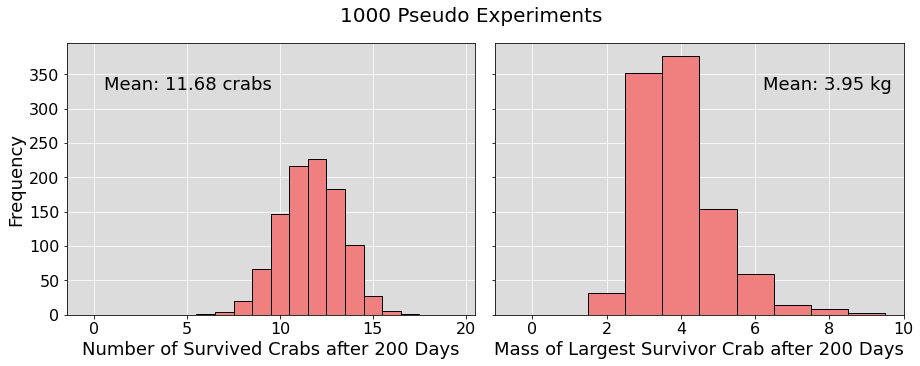

In [25]:
# Plot the results
fig, ax = plt.subplots(ncols=2, figsize=(15,5), sharey=True, gridspec_kw={'wspace':0.05})

# Plot survivor distributions
ax[0].set_facecolor('gainsboro')
ax[0].grid(color='white')
ax[0].hist(N_survivors, color='lightcoral', bins=np.arange(-0.5,20.5,1), ec='k', zorder=2)
ax[0].set_xlabel('Number of Survived Crabs after 200 Days', fontsize=18)
ax[0].set_ylabel('Frequency', fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=16)

# Mark mean
ax[0].text(x=0.5,y=328, s=f'Mean: {np.mean(N_survivors):.2f} crabs', fontsize=18)

# Plot largest mass distributions
ax[1].set_facecolor('gainsboro')
ax[1].grid(color='white')
ax[1].hist(Largest_mass, color='lightcoral', bins=np.arange(-0.5,10.5,1), ec='k', zorder=2)
ax[1].set_xlabel('Mass of Largest Survivor Crab after 200 Days', fontsize=18)

# Mark mean
ax[1].text(x=6.2,y=328, s=f'Mean: {np.mean(Largest_mass):.2f} kg', fontsize=18)

fig.suptitle(f'{N_experiments} Pseudo Experiments', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=16)

plt.show()

# Problem 3D

To solve this question, we modify the battle_simulation function a little, so it counts the number of survivors in each iteration, and returns N_days when the number of survivors are 10.

In [26]:
# Function that simulates crab battle until there are N survivors
def battle_until_N_survivors(positions, N_surv, seed=1, max_steps=500):
    """
    INPUT:
    positions = an array with shape (N_crabs, 2) containing the CARTESIAN cordinates of the crabs
    N_surv = Number of survivor crabs at which the simulation stop
    max_steps = number of days at which the simulation should stop in the unlikely case the crabs dont
                encounter each other and don't die at the rate expected
    
    OUTPUT:
    N_days = the number of days until N_surv was found
    """

    # Set up random seed
    rd.seed(int(seed))
    
    # Number of crabs alive
    N_crabs = len(positions)
    
    # Set up mass, all 1kg
    mass_arr = np.ones(N_crabs) * crab_mass
    
    # Save positions under new name
    cart_pos = positions.copy()
        
    # Loop over days passed
    for i in range(int(max_steps)):
        
        # Check if N_surv is reached and break loop if it is true
        if N_crabs == 10:
            # Return days
            return i+1
        
        # Make new array to store polar coordinates
        polar_pos = np.zeros_like(cart_pos)
    
        # Loop over crabs
        for j in range(N_crabs):
            
            # Convert cartesian to polar coordinates and store
            polar_pos[j] = cart2pol(*cart_pos[j])
            
            # Take crabs for their daily walk and update positions
            polar_pos[j,0], polar_pos[j,1] = daily_move(polar_pos[j,0], polar_pos[j,1], return_dist=False)
        
        # Convert new coordinates back to cartesian coordinates and store in cart_pos
        for k in range(N_crabs):
            cart_pos[k] = pol2cart(*polar_pos[k])
        
        # Find distances between carbs, and get the order crabs need to battle in
        tournament_arr = battle_tournament(cart_pos)
        
        # Check if there were any crabs who needs to battle
        if len(tournament_arr) > 0:
            
            # Let all of them battle
            status_arr, mass_arr = battle(tournament_arr, mass_arr)
            
            # Remove dead crabs, update shape and contents of different things
            N_crabs = np.sum(status_arr)
            cart_pos = cart_pos[status_arr]
            mass_arr = mass_arr[status_arr]
    
    # In case it doesn't return before print that max steps is reached
    print(f'Max Steps Reached with seed {seed}')
    # Return days
    return i+1

In [27]:
# Define number of experiments
N_experiments = 1000

# Empty array to store days used in each simulation
N_days_arr = np.zeros(N_experiments)

# Loop over experiments
for i in tqdm(range(N_experiments)):
    
    # Simulate
    days = battle_until_N_survivors(CrabData, N_surv=10, seed=i, max_steps=1e4)
    
    # Store results
    N_days_arr[i] = days

  0%|          | 0/1000 [00:00<?, ?it/s]

Max Steps Reached with seed 88
Max Steps Reached with seed 244
Max Steps Reached with seed 417
Max Steps Reached with seed 420
Max Steps Reached with seed 575
Max Steps Reached with seed 864


Note 6 iterations surpassed max_steps. This happens even with 1e6 max_steps.

Since the distribution is assymetrical we calculate the lower 1 sigma bound as the
value where the lower tail contains (100%-68.27%)/2 of the distribution. Same thing for the upper 1 sigma bound calculated using the higher tail. The procentages are best seen on a CDF so we plot that. Since our function is not that smooth we interpolate the cdf so we can get the value at where lower tail contains the specific percentage.

In [28]:
# Define the percentages each tail should contain
low_tail = (1-0.6827)/2
high_tail = 1-(1-0.6827)/2

# Calculate the CDF
CDF_x = np.sort(N_days_arr)
CDF_y = np.arange(1, len(N_days_arr)+1) / len(N_days_arr)

# Create an interpolated function for the CDF
CDF_func = interp1d(CDF_y, CDF_x, assume_sorted=True) #on form x(y) = CDF_func(y)

# Get upper and lower Confidence level
lower_CL = CDF_func(low_tail)
upper_CL = CDF_func(high_tail)

# Get the mean and 
mean = np.mean(N_days_arr)

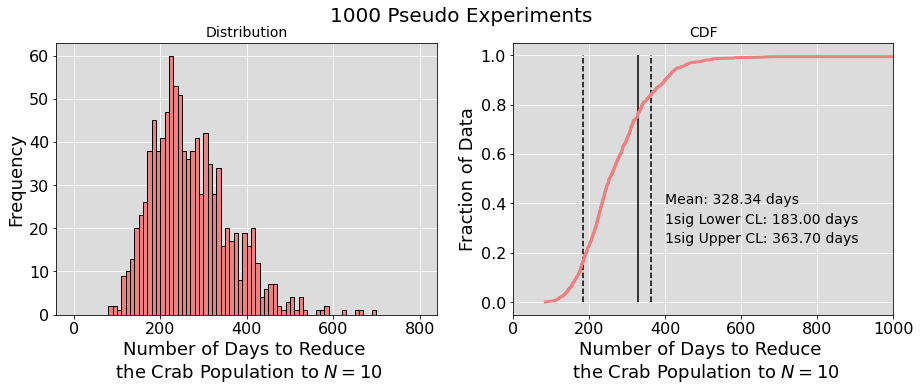

In [29]:
# Plot results
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# Plot distribution ----------------
ax[0].set_facecolor('gainsboro')
ax[0].grid(color='white')
ax[0].hist(N_days_arr, color='lightcoral', bins=np.arange(-0.5,800.5,10), ec='k', zorder=2)

ax[0].set_title('Distribution', fontsize=14)
ax[0].set_xlabel(f'Number of Days to Reduce \n the Crab Population to $N=10$', fontsize=18)
ax[0].set_ylabel('Frequency', fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=16)

# Plot CDF --------------------
ax[1].set_facecolor('gainsboro')
ax[1].grid(color='white')
ax[1].plot(CDF_x, CDF_y, linewidth=3, color='lightcoral')

# Mark mean and confidence levels
ax[1].vlines(mean, 0, 1, color='k')
ax[1].vlines(lower_CL, 0, 1, color='k', linestyle='dashed')
ax[1].vlines(upper_CL, 0, 1, color='k', linestyle='dashed')

ax[1].text(x=400,y=0.4,s=f'Mean: {mean:.2f} days', fontsize=14)
ax[1].text(x=400,y=0.32,s=f'1sig Lower CL: {lower_CL:.2f} days', fontsize=14)
ax[1].text(x=400,y=0.24,s=f'1sig Upper CL: {upper_CL:.2f} days', fontsize=14)

ax[1].set_xlim(0,1000)
ax[1].set_title('CDF', fontsize=14)
ax[1].set_ylabel('Fraction of Data', fontsize=18)
ax[1].set_xlabel(f'Number of Days to Reduce \n the Crab Population to $N=10$', fontsize=18)
ax[1].tick_params(axis='both', which='major', labelsize=16)

# General
fig.suptitle(f'{N_experiments} Pseudo Experiments', fontsize=20)
plt.show()

In [30]:
print(mean, '\t +', upper_CL-mean, '\t -', mean-lower_CL)

328.341 	 + 35.35900000000015 	 - 145.341
